In [1]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

from sklearn import (
    ensemble,
    preprocessing,
    tree,
)
from sklearn.metrics import (
    auc,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
)
from yellowbrick.classifier import (
    ConfusionMatrix,
    ROCAUC,
    PRCurve,
)
from yellowbrick.model_selection import (
    LearningCurve,
)

In [3]:
plt.rcParams.update({'font.size': 16})

## Data

[Vanderbilt Datasets](http://biostat.mc.vanderbilt.edu/wiki/Main/DataSets)

### Gather data

In [4]:
X_train = pd.read_csv('data/X_train.csv')
X_test = pd.read_csv('data/X_test.csv')
y_train = pd.read_csv('data/y_train.csv')
y_test = pd.read_csv('data/y_test.csv')

In [5]:
X_train.head(3)

pclass  sex_male  sex_female       age     sibsp     parch      fare  \
0 -0.357300  0.734868   -0.734868 -0.059075  0.510668 -0.434783 -0.229923   
1 -1.553585  0.734868   -0.734868  1.602868 -0.489262 -0.434783 -0.120442   
2 -1.553585 -1.360788    1.360788  0.469725 -0.489262 -0.434783  2.031380   

   embarked_S  embarked_C  embarked_Q  embarked_  
0    0.649414   -0.501274   -0.321694  -0.045198  
1    0.649414   -0.501274   -0.321694  -0.045198  
2   -1.539849    1.994917   -0.321694  -0.045198

In [6]:
X_test.head(3)

pclass  sex_male  sex_female       age     sibsp     parch      fare  \
0  0.838984 -1.360788    1.360788 -0.890046 -0.489262 -0.434783 -0.485380   
1  0.838984  0.734868   -0.734868 -0.314790 -0.489262 -0.434783 -0.501655   
2 -1.553585  0.734868   -0.734868 -0.361246  0.510668 -0.434783  1.152487   

   embarked_S  embarked_C  embarked_Q  embarked_  
0    0.649414   -0.501274   -0.321694  -0.045198  
1   -1.539849    1.994917   -0.321694  -0.045198  
2   -1.539849    1.994917   -0.321694  -0.045198

In [7]:
y_train.head(3)

survived
0         0
1         1
2         1

In [8]:
y_test.head(3)

survived
0         1
1         0
2         1

### Baseline model

In [9]:
from sklearn.dummy import DummyClassifier

In [10]:
dummy = DummyClassifier(strategy='prior')

In [11]:
dummy.fit(X_train, y_train)
dummy.score(X_test, y_test)

0.6219512195121951

In [12]:
from sklearn.metrics import accuracy_score

In [13]:
accuracy_score(y_test, dummy.predict(X_test))

0.6219512195121951

### Evaluate model families

In [14]:
X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

#### `sklearn` does not like column vectors for the target

In [15]:
y = y.values.ravel()
y_train = y_train.values.ravel()
y_test =y_test.values.ravel()

## Classification

In [16]:
# ! python3 -m pip install --quiet xgboost

In [17]:
from sklearn import model_selection
from sklearn.linear_model import (
    LogisticRegression,
)
from sklearn.tree import (
    DecisionTreeClassifier,
)
from sklearn.neighbors import (
    KNeighborsClassifier,
)
from sklearn.naive_bayes import (
    GaussianNB,
)
from sklearn.svm import (
    SVC,
)
from sklearn.ensemble import (
    RandomForestClassifier,
)
import xgboost

In [18]:
models = [    
    DummyClassifier,
    LogisticRegression,
    DecisionTreeClassifier,
    KNeighborsClassifier,
    GaussianNB,
    SVC,
    RandomForestClassifier,
    xgboost.XGBRFClassifier,
]

In [19]:
for model in models:
    cls = model()
    kfold = model_selection.KFold(
        n_splits=10, 
        shuffle=True,
        random_state=123,
    )
    s = model_selection.cross_val_score(
        cls, X, y, scoring='roc_auc', cv=kfold,
    )
    print(
        f'{model.__name__:22} AUC:'
        f'{s.mean():.3f} STD: {s.std():.2f}'
    )

DummyClassifier        AUC:0.478 STD: 0.06
LogisticRegression     AUC:0.843 STD: 0.04
DecisionTreeClassifier AUC:0.753 STD: 0.04
KNeighborsClassifier   AUC:0.840 STD: 0.03
GaussianNB             AUC:0.824 STD: 0.04
SVC                    AUC:0.848 STD: 0.04
RandomForestClassifier AUC:0.845 STD: 0.03
XGBRFClassifier        AUC:0.866 STD: 0.04


### Stacking

Source: https://miro.medium.com/max/2044/1*5O5_Men2op_sZsK6TTjD9g.png

<img src="https://miro.medium.com/max/2044/1*5O5_Men2op_sZsK6TTjD9g.png" 
     alt="Stacking" style="width: 600px;"/>


In [20]:
from sklearn.ensemble import StackingClassifier

In [21]:
stack = StackingClassifier(estimators=[(m.__name__, m()) for m in models])

In [22]:
s = model_selection.cross_val_score(
    stack, X, y, scoring='roc_auc', cv=kfold,
)
print(
    f'{stack.__class__.__name__:22} AUC:'
    f'{s.mean():.3f} STD: {s.std():.2f}'
)

StackingClassifier     AUC:0.867 STD: 0.04


### Create a model

In [23]:
clf = xgboost.XGBRFClassifier()
clf.fit(X_train, y_train)

XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bytree=1, gamma=0, gpu_id=-1, importance_type='gain',
                interaction_constraints='', max_delta_step=0, max_depth=6,
                min_child_weight=1, missing=nan, monotone_constraints='()',
                n_estimators=100, n_jobs=0, num_parallel_tree=100,
                objective='binary:logistic', random_state=0, reg_alpha=0,
                scale_pos_weight=1, tree_method='exact', validate_parameters=1,
                verbosity=None)

In [24]:
clf.score(X_test, y_test)

0.801829268292683

In [25]:
roc_auc_score(
    y_test, clf.predict(X_test)
)

0.7790164452877926

In [26]:
sorted(zip(X_train.columns, clf.feature_importances_), key=lambda x: -x[1])

[('sex_female', 0.45613697),
 ('sex_male', 0.4237464),
 ('pclass', 0.043916065),
 ('sibsp', 0.02123294),
 ('embarked_C', 0.011571336),
 ('fare', 0.011395166),
 ('parch', 0.008786586),
 ('embarked_S', 0.008488986),
 ('age', 0.0080112945),
 ('embarked_Q', 0.0067142267),
 ('embarked_', 0.0)]

### Optimize model

In [27]:
clf_ = xgboost.XGBRFClassifier()

In [28]:
params = {
    'min_child_weight': [1, 5, 10],
    'gamma': [0, 0.5, 1, 1.5, 2, 5],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'max_depth': [4, 5, 6, 7],
}

In [29]:
clf = model_selection.GridSearchCV(
    clf_, params, n_jobs=-1, 
).fit(X_train, y_train)

In [30]:
clf.best_params_

{'colsample_bytree': 0.6, 'gamma': 1, 'max_depth': 7, 'min_child_weight': 1}

In [31]:
clf.score(X_test, y_test)

0.7957317073170732

In [32]:
clf_best = xgboost.XGBRFClassifier(**clf.best_params_)

### Confusion matrix

In [33]:
from sklearn.metrics import confusion_matrix

In [34]:
clf_best.fit(X_train, y_train)

XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bytree=0.6, gamma=1, gpu_id=-1,
                importance_type='gain', interaction_constraints='',
                max_delta_step=0, max_depth=7, min_child_weight=1, missing=nan,
                monotone_constraints='()', n_estimators=100, n_jobs=0,
                num_parallel_tree=100, objective='binary:logistic',
                random_state=0, reg_alpha=0, scale_pos_weight=1,
                tree_method='exact', validate_parameters=1, verbosity=None)

In [35]:
confusion_matrix(y_test, clf_best.predict(X_test))

array([[178,  26],
       [ 41,  83]])

In [36]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

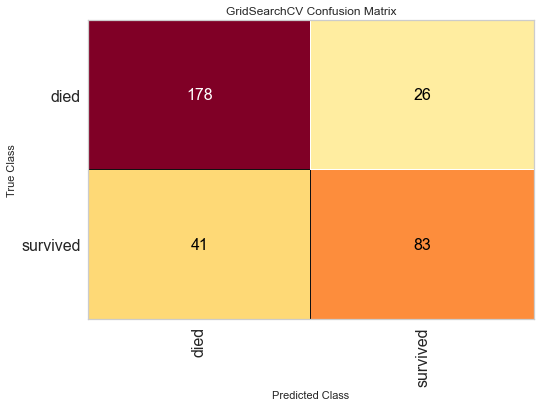

In [37]:
cm_viz = ConfusionMatrix(clf, classes=['died', 'survived'])
cm_viz.fit(X_train, y_train)
cm_viz.score(X_test, y_test)
cm_viz.show();

### ROC curve

In [38]:
roc_auc_score(y_test, clf_best.predict(X_test))

0.7709519291587603

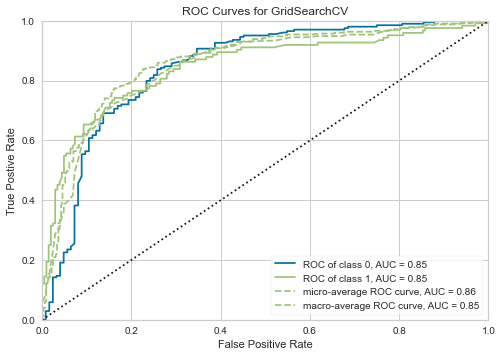

In [39]:
roc_viz = ROCAUC(clf)
roc_viz.fit(X_train, y_train)
roc_viz.score(X_test, y_test)
roc_viz.show();

### Precision-recall curve

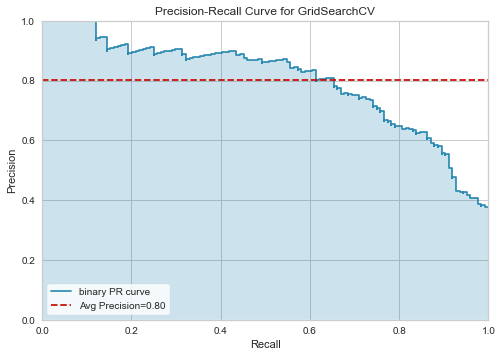

In [40]:
prc_viz = PRCurve(clf)
prc_viz.fit(X_train, y_train)
prc_viz.score(X_test, y_test)
prc_viz.show();

### Learning curve

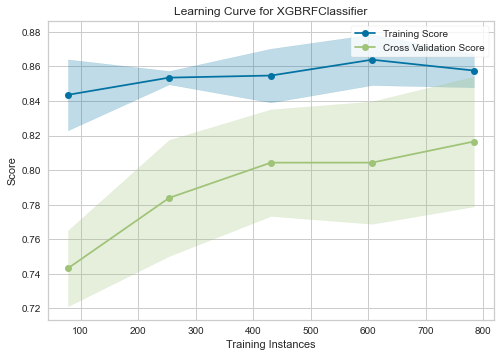

In [41]:
lc_viz = LearningCurve(clf_best)
lc_viz.fit(X_train, y_train)
lc_viz.score(X_test, y_test)
lc_viz.show();

### Model persistence (and deploymnet)

In [42]:
import joblib

In [43]:
joblib.dump(clf_best, 'clf_best.pickle')

['clf_best.pickle']

In [44]:
clf = joblib.load('clf_best.pickle')

In [45]:
clf.score(X_test, y_test)

0.7957317073170732